# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when,count,isnan, desc,asc,col
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#ml imports 
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler , Normalizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer


In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()



[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '3655c39ca561'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1591743017597'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '36561')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## check for nans , duplicates and formating ts
- will get the count of nans,nulls and " " 
- it makes sense for user IDS to be duplicated so that i will leave
- ts is in seconds so i want to check for the hours listened

In [5]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df_pandas = df.toPandas()
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#detecting null values
df.select([count(when(isnan(c) 
               | col(c).isNull(), c)).alias(c)
                for c in df.columns]) \
                .show(1,truncate = False,vertical = True)  


-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     



In [7]:
df.show(1, truncate = False, vertical = True)

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

In [8]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)


In [9]:
df = df.withColumn("hour", get_hour(df.ts))


In [10]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [11]:
#df.select(["userId"]).where(df.userId == "").count()
df.filter(df['userId'] == "").count(),df.filter(df['sessionId'] == "").count()

(8346, 0)

- at first glance it seems like there are no empty userIDs but there are actually blank spaces these will be useless in detecting churn rates so i will just drop them

In [12]:
df = df.dropna(how = 'any',subset = ['userId','sessionId'])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
df.select("page").dropDuplicates().sort("page").show(truncate = False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|NextSong                 |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
+-------------------------+
only showing top 20 rows



In [14]:
#might seem alot less than the number of users we have in the dataset
#however the users who havent churned are duplicated 
df.filter(df['page'] == 'Cancellation Confirmation').count()

52

In [15]:
# all users are duplicated 
df.groupBy(df.userId)\
    .count().show()
    

+------+-----+
|userId|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
|     7|  201|
|    54| 3437|
|    15| 2278|
|   155| 1002|
|   132| 2304|
|   154|  118|
|100014|  310|
|   101| 2149|
|    11|  848|
|   138| 2469|
|300017| 4428|
|    29| 3603|
|    69| 1342|
|100021|  319|
|    42| 4257|
+------+-----+
only showing top 20 rows



In [16]:
#churned users --mostly wont need this
churned_df = df.filter(df['page'] == 'Cancellation Confirmation').select("userId").toPandas()

In [17]:
df.select(["userId", "sessionId", "page", "level", "song"]).filter((col('userId') == '32')).collect()

[Row(userId='32', sessionId=218, page='NextSong', level='free', song='Beyond The Beyond (Instrumental)'),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='Paradise City'),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='Alejandro'),
 Row(userId='32', sessionId=218, page='Roll Advert', level='free', song=None),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='Luv U Better'),
 Row(userId='32', sessionId=218, page='Thumbs Up', level='free', song=None),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='My Life Would Suck Without You'),
 Row(userId='32', sessionId=218, page='Add to Playlist', level='free', song=None),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='Jamaica Roots II(Agora E Sempre)'),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='Dusk'),
 Row(userId='32', sessionId=218, page='NextSong', level='free', song='September'),
 Row(userId='32', sessionId=

In [18]:
hasCancelled = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)


In [19]:
df = df.withColumn("churned", hasCancelled("page"))


In [20]:
df = df.withColumn("churned", Fsum("churned").over(window))


In [21]:
df.show(1,vertical= True,truncate = False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------
 artist        | Sleeping With Sirens                                                                                                                        
 auth          | Logged In                                                                                                                                   
 firstName     | Darianna                                                                                                                                    
 gender        | F                                                                                                                                           
 itemInSession | 0                                                                                                                                           
 lastName      | Carpenter                          

In [22]:
dfp_levels = df.drop_duplicates(['userId','gender']).groupby('level','gender').count().sort('count').toPandas()
dfp_levels

,level,gender,count
0,free,None,1
1,paid,M,21
2,paid,F,27
3,free,F,77
4,free,M,100


In [23]:
df_p = df.toPandas()

In [24]:
df_p_levels = df_p.drop_duplicates(subset = 'userId').groupby(['gender','level']).count()
df_p_levels['userId']

gender  level
F       free      77
        paid      27
M       free     100
        paid      21
Name: userId, dtype: int64

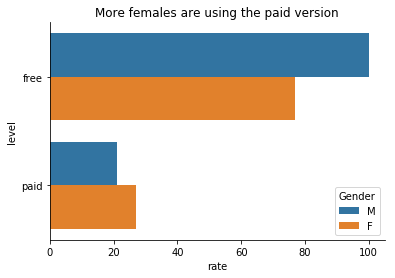

In [25]:
ax = sns.barplot(x = 'count',y = 'level',hue = 'gender' , data = dfp_levels)
plt.xlabel('rate')
plt.ylabel('level')
plt.legend(title='Gender', loc='best')
plt.title('More females are using the paid version')
sns.despine(ax=ax);

In [26]:
df_p['userAgent']

0         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
1         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
2         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
3         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
4         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
5         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
6         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
7         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
8         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
9         "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
10        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
11        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
12        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
13        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
14        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
15        "Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...
16        "Mozilla/5.0 (iPhone; CPU iPho

In [27]:
songs_per_hour_pd = df.filter(df.page == "NextSong").groupby(['hour']).count().withColumnRenamed("count", "nextSongs").toPandas()


In [28]:
songs_per_hour_pd.head()

,hour,nextSongs
0,7,8091
1,15,11354
2,11,8830
3,3,8355
4,8,8253


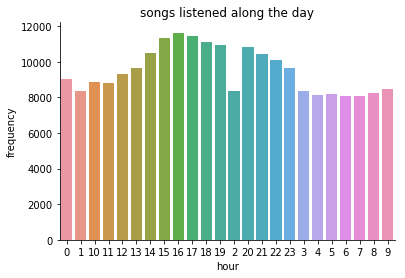

In [29]:
ax = sns.barplot(x = 'hour',y = 'nextSongs', data = songs_per_hour_pd)
plt.xlabel('hour')
plt.ylabel('frequency')
plt.title('songs listened along the day')
sns.despine(ax=ax);

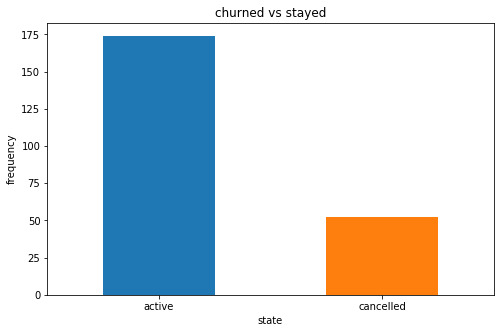

In [30]:
ax =  df_p.drop_duplicates(subset = ['userId'])['churned'].value_counts().plot(
                                kind='bar', figsize=(8,5), 
                                title='churned vs stayed');
ax.set_xlabel('state');
ax.set_xticklabels(['active','cancelled'], rotation=0)
ax.set_ylabel('frequency');
    
    


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### features in mind:
- Tracking pages:
-    added to playlist +
-    Error -
-    thumgs Down -
-    thumbs up +
-    upgrade +
- number of songs + 

 

In [31]:
#this shows teh maximum count listened to by the users came in 3 pm
songs_in_hour = df.filter(df.page == "NextSong").groupby(['userId']).count().withColumnRenamed("count", "nextSongs")
songs_in_hour.describe().show()

+-------+------------------+------------------+
|summary|            userId|         nextSongs|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



In [32]:
added_to_playlist = df.filter(df.page == 'Add to Playlist').groupby(['userId']).count() \
.withColumnRenamed("count", "addToPlaylist")
added_to_playlist.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    addToPlaylist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [33]:
errors = df.filter(df.page == "Error").groupby(['userId']).count().withColumnRenamed("count", "Error")
errors.describe().show()

+-------+------------------+------------------+
|summary|            userId|             Error|
+-------+------------------+------------------+
|  count|               118|               118|
|   mean| 67580.35897435897|2.1864406779661016|
| stddev|110479.86962560513|1.4319262774221952|
|    min|                  |                 1|
|    max|                98|                 7|
+-------+------------------+------------------+



In [34]:
total_songs = df.filter(df.page == "NextSong").groupby(['userId']).count().withColumnRenamed("count", "NextSong")
total_songs.describe().show()

+-------+------------------+------------------+
|summary|            userId|          NextSong|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



In [35]:
thumbs_down = df.filter(df.page == "Thumbs Down").groupby(['userId']).count().withColumnRenamed("count", "thumbsDowns")
thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userId|       thumbsDowns|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [36]:
thumbs_up = df.filter(df.page == "Thumbs Up").groupby(['userId']).count().withColumnRenamed("count", "thumbsUps")
thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userId|        thumbsUps|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



#### reflection : most of the values are not deviating alot from the mean however using the standard scaler would make the results even more accurate

In [37]:
# Churn label
label = df['userId','churned'].withColumnRenamed("churned", "label").dropDuplicates()
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [38]:
data = songs_in_hour.join(added_to_playlist,'userID','outer') \
.join(errors,'userID','outer') \
.join(total_songs,'userID','outer') \
.join(thumbs_down,'userID','outer') \
.join(thumbs_up,'userID','outer') \
.join(label,'userId','outer') \
.drop('userId') \
.fillna(0)

data.show(10)

+---------+-------------+-----+--------+-----------+---------+-----+
|nextSongs|addToPlaylist|Error|NextSong|thumbsDowns|thumbsUps|label|
+---------+-------------+-----+--------+-----------+---------+-----+
|      275|            7|    0|     275|          5|       17|    0|
|      387|            8|    0|     387|          6|       21|    0|
|        8|            0|    0|       8|          0|        0|    1|
|     4079|          118|    6|    4079|         41|      171|    0|
|     2111|           52|    1|    2111|         21|      100|    1|
|      150|            5|    1|     150|          1|        7|    0|
|     1914|           59|    2|    1914|         14|       81|    0|
|     2841|           72|    1|    2841|         29|      163|    1|
|      820|           24|    3|     820|          3|       58|    0|
|      257|            7|    0|     257|          3|       17|    1|
+---------+-------------+-----+--------+-----------+---------+-----+
only showing top 10 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
#vector assembler
#nextSongs|addToPlaylist|Error|NextSong|thumbsDowns|thumbsUps|
cols = ['nextSongs','addToPlaylist','Error','NextSong','thumbsDowns','thumbsUps']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

In [40]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [41]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
validation, testData = testData.randomSplit([0.5, 0.5], seed=42)

In [42]:
clasification_algorithms = {'randomForest': [], 'gradientBoostedTree': [],'logisticRegression':[],'SVM' : []}

random_forest_list = []
gradient_list = []
logistic_list = []
svm_list = []

### random forest

In [43]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2).fit(data)



In [44]:




# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])


# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=pipeline,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)



accuracy = evaluator.evaluate(predictions)
F1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " % accuracy)
print("F1 score = %g " % F1_score)
rfModel = model.stages[2]
print(rfModel)  # summary only


Test Error = 0.166667
accuracy = 0.833333 
F1 score = 0.819355 
RandomForestClassificationModel (uid=RandomForestClassifier_b06ebde0026c) with 10 trees


In [45]:
random_forest_list.append(accuracy)
random_forest_list.append(1 - accuracy)
random_forest_list.append(F1_score)




In [46]:
clasification_algorithms['randomForest'] = random_forest_list

### gradient boosted Tree

In [47]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=pipeline,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
F1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " % accuracy)
print("F1 score = %g " % F1_score)
gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[3.69286258505468...|
|       0.0|         0.0|[1.73281171556623...|
|       0.0|         1.0|[2.57205751511163...|
|       0.0|         0.0|[0.74237492516421...|
|       0.0|         0.0|[0.07604816306560...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.236111
accuracy = 0.763889 
F1 score = 0.753799 
GBTClassificationModel (uid=GBTClassifier_1168c1b347eb) with 10 trees


In [48]:
gradient_list.append(accuracy)
gradient_list.append(1 - accuracy)
gradient_list.append(F1_score)


In [49]:
clasification_algorithms['gradientBoostedTree'] = gradient_list

### Testing logistic regression

In [50]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, lr])


# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=pipeline,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
F1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " % accuracy)
print("F1 score = %g " % F1_score)
lr_model = model.stages[2]
print(lr_model)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[0.35036475126652...|
|       0.0|         0.0|[0.13580029118857...|
|       0.0|         0.0|[0.74237492516421...|
|       0.0|         1.0|[0.23267116556976...|
|       0.0|         1.0|[1.62688748843914...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.190476
accuracy = 0.809524 
F1 score = 0.752715 
LogisticRegressionModel: uid = LogisticRegression_04dd0f845e7c, numClasses = 2, numFeatures = 6


In [51]:
logistic_list.append(accuracy)
logistic_list.append(1- accuracy)
logistic_list.append(F1_score)

In [52]:
clasification_algorithms['logisticRegression'] = logistic_list

In [53]:
clasification_algorithms


{'randomForest': [0.8333333333333334, 0.16666666666666663, 0.8193548387096774],
 'gradientBoostedTree': [0.7638888888888888,
  0.23611111111111116,
  0.7537986704653372],
 'logisticRegression': [0.8095238095238095,
  0.19047619047619047,
  0.7527151211361738],
 'SVM': []}

### Testing SVM

In [54]:
#clasification_algorithms = {'randomForest': [], 'gradientBoostedTree': [],'logisticRegression':[],'SVM' : []}
len(svm_list),len(logistic_list),len(gradient_list),len(random_forest_list)


(0, 3, 3, 3)

In [55]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
svc = LinearSVC(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, svc])


# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=pipeline,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
F1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " % accuracy)
print("F1 score = %g " % F1_score)
svm_model = model.stages[2]
print(svm_model)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[0.74237492516421...|
|       0.0|         0.0|[0.07604816306560...|
|       0.0|         0.0|[1.74548640941050...|
|       0.0|         0.0|[1.87404401840235...|
|       0.0|         0.0|[3.23476293611188...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.185714
accuracy = 0.814286 
F1 score = 0.730934 
LinearSVC_292a5c014456


In [56]:
svm_list.append(accuracy)
svm_list.append(1 - accuracy)
svm_list.append(F1_score)

In [57]:
clasification_algorithms['SVM'] = svm_list

In [58]:
clasification_algorithms

{'randomForest': [0.8333333333333334, 0.16666666666666663, 0.8193548387096774],
 'gradientBoostedTree': [0.7638888888888888,
  0.23611111111111116,
  0.7537986704653372],
 'logisticRegression': [0.8095238095238095,
  0.19047619047619047,
  0.7527151211361738],
 'SVM': [0.8142857142857143, 0.18571428571428572, 0.7309336332958379]}

### Scores

In [59]:
scores_df = pd.DataFrame.from_dict(clasification_algorithms)
scores_df = scores_df.T


In [60]:
scores_df = scores_df.rename(columns={0: "accuracy",1: "error" ,2:"F1_score"})
scores_df['algorithms'] = scores_df.index
scores_df

,accuracy,error,F1_score,algorithms
randomForest,0.833333,0.166667,0.819355,randomForest
gradientBoostedTree,0.763889,0.236111,0.753799,gradientBoostedTree
logisticRegression,0.809524,0.190476,0.752715,logisticRegression
SVM,0.814286,0.185714,0.730934,SVM


In [61]:
scores_df

,accuracy,error,F1_score,algorithms
randomForest,0.833333,0.166667,0.819355,randomForest
gradientBoostedTree,0.763889,0.236111,0.753799,gradientBoostedTree
logisticRegression,0.809524,0.190476,0.752715,logisticRegression
SVM,0.814286,0.185714,0.730934,SVM


In [62]:
tidy = scores_df.melt(id_vars='algorithms').rename(columns=str.title)
tidy

,Algorithms,Variable,Value
0,randomForest,accuracy,0.833333
1,gradientBoostedTree,accuracy,0.763889
2,logisticRegression,accuracy,0.809524
3,SVM,accuracy,0.814286
4,randomForest,error,0.166667
5,gradientBoostedTree,error,0.236111
6,logisticRegression,error,0.190476
7,SVM,error,0.185714
8,randomForest,F1_score,0.819355
9,gradientBoostedTree,F1_score,0.753799


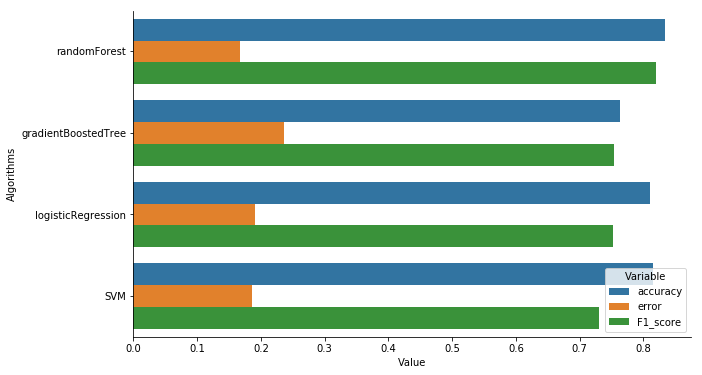

In [63]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x='Value', y='Algorithms', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

In [64]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2).fit(data)




# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])


# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# build paramGrid
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30]).build()


crossval_lr = CrossValidator(estimator=pipeline,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)



accuracy = evaluator.evaluate(predictions)
F1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " % accuracy)
print("F1 score = %g " % F1_score)
rfModel = model.stages[2]
print(rfModel)  # summary only


Test Error = 0.214286
accuracy = 0.785714 
F1 score = 0.716571 
RandomForestClassificationModel (uid=RandomForestClassifier_a7a51166cc30) with 10 trees


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.